In [74]:
import pandas as pd
import numpy  as np

df = pd.read_csv('data/googleplaystore.csv')

# fill in Types since it can be implied from Price
a = df.Type.isna()
for i in range(len(df.Type)):
    if a[i] == True:
        if df.Price[i] == "0":
            df.Type[i] = "Free"
        else:
            df.Type[i] = "Paid"
            
# treat missing values in Content Rating
df["Content Rating"].replace(to_replace=np.nan,value = "missing", inplace=True)

# reserve missing datapoints in Rating as test set
df_test = df.iloc[list(np.where(np.isnan(df.Rating))[0])]

# drop missing values
df.dropna(inplace = True)   #remove missing entries
df.reset_index(drop=True, inplace=True)

# convert the type of Reviews from object to int
df['Reviews'] = df['Reviews'].astype(int)

# preprocess size
df['Size varies'] = df.Size.apply(lambda x: 1 if 'Varies' in x else 0)
df.Size = df.Size.replace('Varies with device',np.nan)
df.Size = df.Size.str.replace('k','e+3')
df.Size = df.Size.str.replace('M','e+6')
df.Size = pd.to_numeric(df.Size)
df.Size = df.Size/1000000

# preprocess price
df.Price = df.Price.apply(lambda x: x.strip('$'))
df.Price = pd.to_numeric(df.Price)

# preprocess genres
# split_genres1 = df.Genres.apply(lambda x: x.split(';')[0])
# split_genres2 = df.Genres.apply(lambda x: x.split(';')[-1])
# df["First Genre"]=split_genres1
# df["Second Genre"]=split_genres2

# preprocess last updated
from datetime import datetime,date
update_date=pd.to_datetime(df["Last Updated"])
df["Updated Days"] = update_date.apply(lambda x:date.today()-datetime.date(x))
df["Updated Days"] = df["Updated Days"].astype(int)
df["Updated Days"] = df["Updated Days"] / 864e+11

# preprocess current ver
import re
df["Current Ver"]=df["Current Ver"].apply(lambda x: 'Varies with device' if x=='Varies with device'  else  re.findall('^[0-9]\.[0-9]|[\d]|\W*',str(x))[0])
#df['Current ver varies'] = df['Current Ver'].apply(lambda x: 1 if 'Varies' in x else 0)
#df["Current Ver"].replace(to_replace="Varies with device",value = "0", inplace=True)
df["Current Ver"].replace(to_replace="",value = "0", inplace=True)
# df["Current Ver"] = pd.to_numeric(df["Current Ver"])
# uniq_ver = df["Current Ver"].unique()
# ord_ver = sorted(uniq_ver)

# preprocess android ver
#df['Android ver varies'] = df['Android Ver'].apply(lambda x: 1 if 'Varies' in x else 0)
df["Min Ver"]=df["Android Ver"].apply(lambda x:str(x).split(' and ')[0].split(' - ')[0])
df["Min Ver"]=df["Min Ver"].replace('4.4W','4.4')
df["Max Ver"]=df["Android Ver"].apply(lambda x:str(x).split(' and ')[-1].split(' - ')[-1])
df["Min Ver"]=df["Min Ver"].apply(lambda x: 'Varies with device' if x=='Varies with device'  else  re.findall('^[0-9]\.[0-9]|[\d]|\W*',str(x))[0])
df["Max Ver"]=df["Max Ver"].apply(lambda x: 'Varies with device' if x=='Varies with device'  else  ('9.0' if 'up' in x else re.findall('^[0-9]\.[0-9]|[\d]|\W*',str(x)))[0])
#df["Min Ver"].replace(to_replace="Varies with device",value = "0", inplace=True)
#df["Max Ver"].replace(to_replace="Varies with device",value = "0", inplace=True)
# a1 = df["Min Ver"].unique()
# ord_min = sorted(a1)
# a2 = df["Max Ver"].unique()
# ord_max = sorted(a2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


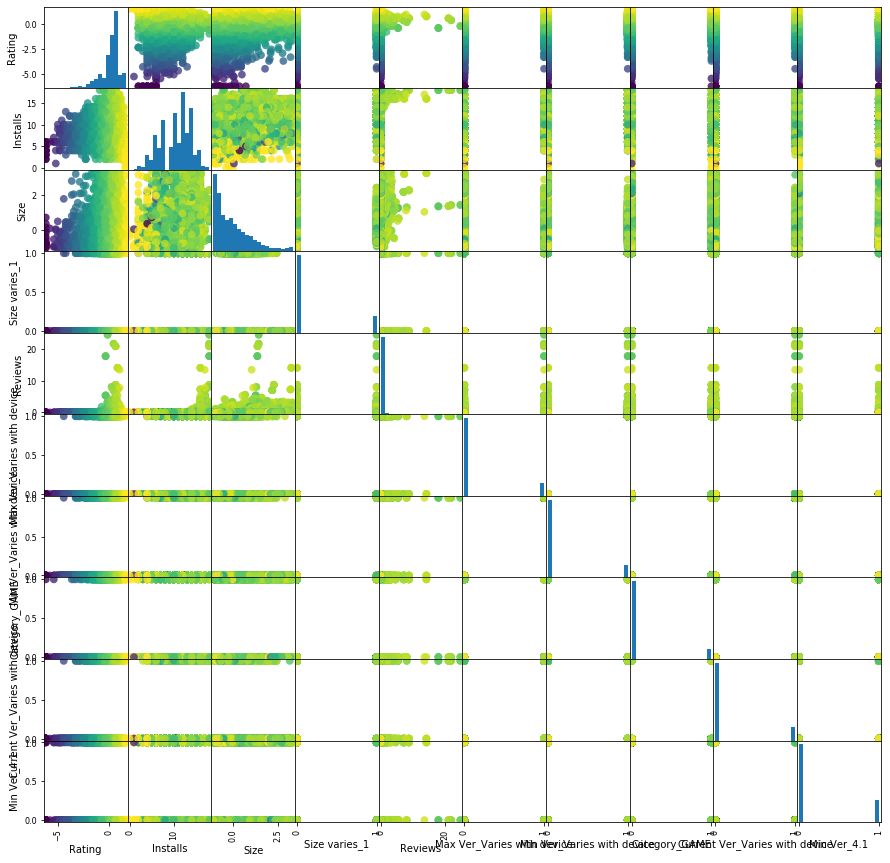

In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

X_train = df
con_ftrs = ['Reviews','Size','Price','Updated Days','Rating']
onehot_ftrs = ['Category','Size varies','Type','Content Rating','Genres',\
               'Current Ver','Min Ver','Max Ver']
ord_ftrs = ['Installs']
ord_cats = [['1+','5+','10+','50+','100+','500+','1,000+','5,000+','10,000+','50,000+','100,000+','500,000+',\
             '1,000,000+','5,000,000+','10,000,000+','50,000,000+','100,000,000+','500,000,000+','1,000,000,000+']]

ohe = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
orde = OrdinalEncoder(categories = ord_cats)
scaler = StandardScaler()
iter_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators = 100),random_state=100)

scaler_train = scaler.fit_transform(iter_imputer.fit_transform(X_train[con_ftrs]))
X_train_con = pd.DataFrame(data=scaler_train, columns = con_ftrs)
X_train_onehot = pd.DataFrame(data=ohe.fit_transform(X_train[onehot_ftrs]), columns = ohe.get_feature_names(onehot_ftrs))
X_train_ord = pd.DataFrame(data=orde.fit_transform(X_train[ord_ftrs]), columns = ord_ftrs)
X_train_df = pd.concat([X_train_con, X_train_onehot, X_train_ord],axis = 1)


import matplotlib
from matplotlib import pylab as plt

corrmat = X_train_df.corr()

all_cols = corrmat.sort_values('Rating',ascending=False)['Rating'].index 
cols = all_cols[:10] # positively correlated features

pd.plotting.scatter_matrix(X_train_df[cols],c = X_train_df['Rating'], figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.savefig('figures/scatter_matrix.png',dpi=300)
plt.show()
X_train_df.drop(columns=['Rating'],inplace=True)
features = X_train_df.columns

In [75]:
y = df.Rating
df.drop(columns=['Rating'],inplace=True)
X = df

In [76]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def split_preprocess(X_train,X_CV,X_test,random_state):
#     con_ftrs = ['Reviews','Size','Price','Updated Days']
#     onehot_ftrs = ['Category','Size varies','Type','Content Rating']
#     ord_ftrs = ['Installs']
#     ord_cats = [['1+','5+','10+','50+','100+','500+','1,000+','5,000+','10,000+','50,000+','100,000+','500,000+',\
#                  '1,000,000+','5,000,000+','10,000,000+','50,000,000+','100,000,000+','500,000,000+','1,000,000,000+']]
    con_ftrs = ['Reviews','Size','Price','Updated Days']
    onehot_ftrs = ['Category','Size varies','Type','Content Rating','Genres',\
                   'Current Ver','Min Ver','Max Ver']
    ord_ftrs = ['Installs']
    ord_cats = [['1+','5+','10+','50+','100+','500+','1,000+','5,000+','10,000+','50,000+','100,000+','500,000+',\
                 '1,000,000+','5,000,000+','10,000,000+','50,000,000+','100,000,000+','500,000,000+','1,000,000,000+']]

    ohe = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
    orde = OrdinalEncoder(categories = ord_cats)
    scaler = StandardScaler()
    iter_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators = 100),random_state=100)

    scaler_train = scaler.fit_transform(iter_imputer.fit_transform(X_train[con_ftrs]))
    X_train_con = pd.DataFrame(data=scaler_train, columns = con_ftrs)
    X_train_onehot = pd.DataFrame(data=ohe.fit_transform(X_train[onehot_ftrs]), columns = ohe.get_feature_names(onehot_ftrs))
    X_train_ord = pd.DataFrame(data=orde.fit_transform(X_train[ord_ftrs]), columns = ord_ftrs)

    scaler_cv = scaler.transform(iter_imputer.transform(X_CV[con_ftrs]))
    X_c_con = pd.DataFrame(data=scaler_cv, columns = con_ftrs)
    X_c_onehot = pd.DataFrame(data=ohe.transform(X_CV[onehot_ftrs]), columns = ohe.get_feature_names(onehot_ftrs))
    X_c_ord = pd.DataFrame(data=orde.transform(X_CV[ord_ftrs]), columns = ord_ftrs)

    scaler_test = scaler.transform(iter_imputer.transform(X_test[con_ftrs]))
    X_t_con = pd.DataFrame(data=scaler_test, columns = con_ftrs)
    X_t_onehot = pd.DataFrame(data=ohe.transform(X_test[onehot_ftrs]), columns = ohe.get_feature_names(onehot_ftrs))
    X_t_ord = pd.DataFrame(data=orde.transform(X_test[ord_ftrs]), columns = ord_ftrs)

    X_train_df = pd.concat([X_train_con, X_train_onehot, X_train_ord],axis = 1)
    X_c_df = pd.concat([X_c_con, X_c_onehot, X_c_ord],axis = 1)
    X_t_df = pd.concat([X_t_con, X_t_onehot, X_t_ord],axis = 1)
    return X_train_df,X_c_df,X_t_df

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def ML_pipeline_Lasso(X,y,random_state):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    test_MSE = []
    alpha_opt = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

        X_train_df,X_c_df,X_t_df = split_preprocess(X_train,X_CV,X_test,random_state)

        # tune hyper-parameter, alpha
        alpha = np.logspace(-10,10,num=20)
        CV_score = []
        regs = []
        for a in alpha:
            reg = Lasso(alpha = a, max_iter = 10000)
            reg.fit(X_train_df,y_train)
            CV_score.append(reg.score(X_c_df, y_CV))
            regs.append(reg)

        # find the best alpha in this fold
        alpha_opt.append(alpha[np.argmax(CV_score)])
        # grab the best model
        reg = regs[np.argmax(CV_score)]
        # calculate test score using thee best model
        test_scores.append(reg.score(X_t_df, y_test))
        test_MSE.append(mean_squared_error(y_test,reg.predict(X_t_df)))

    best_alpha = alpha_opt[np.argmax(test_scores)]
    return best_alpha, test_scores, test_MSE

In [58]:
ML_pipeline_Lasso(X,y,42)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.213119259921, tolerance: 0.1613746058430716
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.89308015292943, tolerance: 0.1613746058430716
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361.0444267434917, tolerance: 0.1613746058430716
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.718304726

(0.00020691380811147902,
 [0.05179266387394177,
  0.05659203416940217,
  0.056630785354306434,
  0.04554529622775494,
  0.05564310823534702],
 [0.24498899395149543,
  0.24374897728479333,
  0.24373896511399223,
  0.246603130708481,
  0.24399415194339535])

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def ML_pipeline_Ridge(X,y,random_state):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    test_MSE = []
    alpha_opt = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

        X_train_df,X_c_df,X_t_df = split_preprocess(X_train,X_CV,X_test,random_state)

        # tune hyper-parameter, alpha
        alpha = np.logspace(-10,10,num=20)
        CV_score = []
        regs = []
        for a in alpha:
            reg = Ridge(alpha = a)
            reg.fit(X_train_df,y_train)
            CV_score.append(reg.score(X_c_df, y_CV))
            regs.append(reg)

        # find the best alpha in this fold
        alpha_opt.append(alpha[np.argmax(CV_score)])
        # grab the best model
        reg = regs[np.argmax(CV_score)]
        # calculate test score using thee best model
        test_scores.append(reg.score(X_t_df, y_test))
        test_MSE.append(mean_squared_error(y_test,reg.predict(X_t_df)))

    best_alpha = alpha_opt[np.argmax(test_scores)]
    return best_alpha, test_scores, test_MSE

In [29]:
test_scores = []
test_MSEs = []

for i in range(10):
    best_alpha, test_score, test_MSE = ML_pipeline_Ridge(X,y,i*42)
    test_scores.append(test_score)
    test_MSEs.append(test_MSE)
    print('random_state:', i*42, 'best_alpha:', best_alpha)

print('test score:',np.around(np.mean(test_scores),3),'+/-',np.around(np.std(test_scores),3))
print('test MSE:',np.around(np.mean(test_MSEs),3),'+/-',np.around(np.std(test_MSEs),3))

random_state: 0 best_alpha: 3.359818286283774
random_state: 42 best_alpha: 37.92690190732238
random_state: 84 best_alpha: 37.92690190732238
random_state: 126 best_alpha: 3.359818286283774
random_state: 168 best_alpha: 37.92690190732238
random_state: 210 best_alpha: 37.92690190732238
random_state: 252 best_alpha: 37.92690190732238
random_state: 294 best_alpha: 37.92690190732238
random_state: 336 best_alpha: 37.92690190732238
random_state: 378 best_alpha: 37.92690190732238
test score: 0.065 +/- 0.012
test MSE: 0.246 +/- 0.012


In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def ML_pipeline_RF(X,y,random_state):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    test_MSE = []
    bestpara_opt = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
        
        X_train_df,X_c_df,X_t_df = split_preprocess(X_train,X_CV,X_test,random_state)

        # tune hyper-parameter
        depth = [d for d in range(1,20,5)]
        split = [s for s in range(10,100,10)]
        dep_spl = [(d, s) for d in depth for s in split]
        CV_score_rf = []
        rfs = []
        for d, s in dep_spl:
            clf = RandomForestRegressor(n_estimators=100,max_depth=d,min_samples_split = s,n_jobs=-1,random_state=random_state)
            clf.fit(X_train_df,y_train)
            CV_score_rf.append(clf.score(X_c_df,y_CV))
            rfs.append(clf)
        
        best_rf = max(CV_score_rf)
        bestpara_opt.append(dep_spl[CV_score_rf.index(best_rf)])
        
        # grab the best model
        rf = rfs[np.argmax(CV_score_rf)]
        # calculate test score using the best model
        test_scores.append(rf.score(X_t_df, y_test))
        test_MSE.append(mean_squared_error(y_test,rf.predict(X_t_df)))
    best_para = bestpara_opt[np.argmax(test_scores)]
    return best_para, test_scores, test_MSE

In [33]:
test_scores = []
test_MSEs = []

for i in range(10):
    best_para, test_score, test_MSE = ML_pipeline_RF(X,y,i*42)
    test_scores.append(test_score)
    test_MSEs.append(test_MSE)
    print('random_state:', i*42, 'best depth:', best_para[0],'best split:', best_para[1])

print('test score:',np.around(np.mean(test_scores),3),'+/-',np.around(np.std(test_scores),3))
print('test MSE:',np.around(np.mean(test_MSEs),3),'+/-',np.around(np.std(test_MSEs),3))

random_state: 0 best depth: 16 best split: 20
random_state: 42 best depth: 16 best split: 10
random_state: 84 best depth: 16 best split: 60
random_state: 126 best depth: 16 best split: 10
random_state: 168 best depth: 16 best split: 10
random_state: 210 best depth: 16 best split: 10
random_state: 252 best depth: 16 best split: 10
random_state: 294 best depth: 16 best split: 20
random_state: 336 best depth: 16 best split: 10
random_state: 378 best depth: 16 best split: 40
test score: 0.176 +/- 0.017
test MSE: 0.217 +/- 0.012


In [7]:
# depth = [d for d in range(1,20,5)]
# split = [s for s in range(100,300,10)]

random_state: 0 best depth: 16 best split: 200
random_state: 42 best depth: 16 best split: 100
random_state: 84 best depth: 16 best split: 100
random_state: 126 best depth: 16 best split: 100
random_state: 168 best depth: 16 best split: 180
random_state: 210 best depth: 16 best split: 100
random_state: 252 best depth: 16 best split: 200
random_state: 294 best depth: 16 best split: 100
random_state: 336 best depth: 16 best split: 110
random_state: 378 best depth: 16 best split: 100
test score: 0.166 +/- 0.013


In [23]:
# only with Size, Size varies, Installs, Reviews
ML_pipeline_RF(X,y,42)

((6, 3),
 [0.10733265629030553,
  0.12714774106921645,
  0.09992228879787646,
  0.08923944013374352,
  0.11635893060731284])

In [10]:
# depth = [d for d in range(1,20,5)]
# split = [s for s in range(3,15,5)]

random_state: 0 best depth: 16 best split: 3
random_state: 42 best depth: 16 best split: 8
random_state: 84 best depth: 16 best split: 13
random_state: 126 best depth: 16 best split: 8
random_state: 168 best depth: 16 best split: 13
random_state: 210 best depth: 16 best split: 13
random_state: 252 best depth: 16 best split: 3
random_state: 294 best depth: 16 best split: 13
random_state: 336 best depth: 16 best split: 8
random_state: 378 best depth: 16 best split: 8
test score: 0.177 +/- 0.018


In [21]:
# depth = [d for d in range(1,10,2)]
# split = [s for s in range(3,15,5)]

random_state: 0 best depth: 9 best split: 8
random_state: 42 best depth: 9 best split: 3
random_state: 84 best depth: 9 best split: 13
random_state: 126 best depth: 9 best split: 8
random_state: 168 best depth: 9 best split: 13
random_state: 210 best depth: 9 best split: 13
random_state: 252 best depth: 9 best split: 3
random_state: 294 best depth: 9 best split: 13
random_state: 336 best depth: 9 best split: 13
random_state: 378 best depth: 9 best split: 3
test score: 0.151 +/- 0.015


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVR

def ML_pipeline_SVR(X,y,random_state):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    bestpara_opt = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

        X_train_df,X_c_df,X_t_df = split_preprocess(X_train,X_CV,X_test,random_state)

        # tune hyper-parameter
#         C = np.logspace(-3, 3, 5) 
#         gamma = np.logspace(-5, 5, 5)
        C = np.logspace(-3, 3, 5)
        gamma = np.logspace(-3, 3, 5)
        C_gamma = [(c,g) for c in C for g in gamma]
        CV_score_svr = []
        svrs = []

        for c,g in C_gamma:
            clf = SVR(gamma = g, C = c)
            clf.fit(X_train_df,y_train)
            CV_score_svr.append(clf.score(X_c_df,y_CV))
            svrs.append(clf)
            
        bestpara_opt.append(C_gamma[np.argmax(CV_score_svr)])
        svr = svrs[np.argmax(CV_score_svr)]
        # calculate test score using the best model
        test_scores.append(svr.score(X_t_df, y_test))
    best_para = bestpara_opt[np.argmax(test_scores)]
    return best_para, test_scores

In [5]:
ML_pipeline_SVR(X,y,84)

((1.0, 1.0),
 [0.09893715593038932,
  0.08765123306357181,
  0.09668303453970206,
  0.10359524296947564,
  0.0983287493044872])

In [36]:
ML_pipeline_SVR(X,y,42)

((1.0, 1.0),
 [0.10619470635427253,
  0.10916663682894479,
  0.09419189702765762,
  0.05092407183008696,
  0.06732966739627655])

In [ ]:
# cannot all run
test_scores = []

for i in range(5):
    best_para, test_score = ML_pipeline_SVR(X,y,i*42)
    test_scores.append(test_score)
    print('random_state:', i*42, 'best C:', best_para[0],'best gamma:', best_para[1])

print('test MSE:',np.around(np.mean(test_scores),3),'+/-',np.around(np.std(test_scores),3))

random_state: 0 best C: 1.0 best gamma: 1.0
random_state: 42 best C: 1.0 best gamma: 1.0
random_state: 84 best C: 1.0 best gamma: 1.0
random_state: 126 best C: 1.0 best gamma: 1.0
random_state: 168 best C: 1.0 best gamma: 1.0
random_state: 210 best C: 1.0 best gamma: 1.0
random_state: 252 best C: 1.0 best gamma: 1.0
random_state: 294 best C: 1.0 best gamma: 1.0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb

def ML_pipeline_XGB(X,y,random_state):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    test_scores = []
    test_MSE = []
    bestpara_opt = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

        X_train_df,X_c_df,X_t_df = split_preprocess(X_train,X_CV,X_test,random_state)

        depth = [3,30,100]
        rate = [0.01, 0.05, 0.1, 0.3]
        d_w = [(d,w) for d in depth for w in rate]
        CV_score_xgb = []
        xgbs = []

        for d,w in d_w:
            gbm = xgb.XGBRegressor(n_estimators=20000,
                           max_depth=d,
                           objective="reg:squarederror",
                           learning_rate=w,
                           subsample=1,
                           min_child_weight=3,
                           colsample_bytree=0.8)
            
            clf = gbm.fit(X_train_df, y_train, eval_set=[(X_train_df,y_train),(X_c_df,y_CV)],early_stopping_rounds=50,verbose=False)
            CV_score_xgb.append(clf.score(X_c_df,y_CV))
            xgbs.append(clf)
        
        best_xgb = max(CV_score_xgb)
        bestpara_opt.append(d_w[CV_score_xgb.index(best_xgb)])
        
        # grab the best model
        best_xgb = xgbs[np.argmax(CV_score_xgb)]
        # calculate test score using the best model
        test_scores.append(best_xgb.score(X_t_df, y_test))
        test_MSE.append(mean_squared_error(y_test,best_xgb.predict(X_t_df)))
    best_para = bestpara_opt[np.argmax(test_scores)]
    return best_para, test_scores, test_MSE

In [45]:
test_scores = []
test_MSEs = []

for i in range(5):
    best_para, test_score, test_MSE = ML_pipeline_XGB(X,y,i*42)
    test_scores.append(test_score)
    test_MSEs.append(test_MSE)
    print('random_state:', i*42, 'best depth:', best_para[0],'best weight:', best_para[1])

print('test score:',np.around(np.mean(test_scores),3),'+/-',np.around(np.std(test_scores),3))
print('test MSE:',np.around(np.mean(test_MSEs),3),'+/-',np.around(np.std(test_MSEs),3))

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/x

random_state: 0 best depth: 30 best weight: 5


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/x

random_state: 42 best depth: 100 best weight: 5


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/x

random_state: 84 best depth: 3 best weight: 3


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/x

random_state: 126 best depth: 3 best weight: 1


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/x

random_state: 168 best depth: 30 best weight: 5
test score: 0.171 +/- 0.021
test MSE: 0.226 +/- 0.008


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:09:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


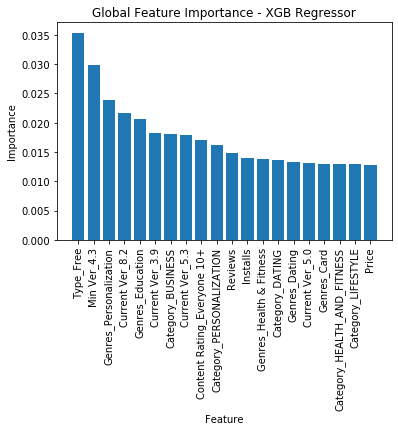

In [81]:
random_state = 84
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state = random_state)
X_train_df,X_c_df,X_t_df = split_preprocess(X_train,X_CV,X_test,random_state)

gbm = xgb.XGBRegressor(n_estimators=20000,
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=0.05,
                       subsample=1,
                       min_child_weight=3,
                       colsample_bytree=0.8)

rgs = gbm.fit(X_train_df, y_train, eval_set=[(X_train_df,y_train),(X_c_df,y_CV)],early_stopping_rounds=50,verbose=False)
test_score=gbm.score(X_t_df, y_test)

features_df = pd.DataFrame()
features_df['Features'] = X_train_df.columns
features_df['Importance'] = gbm.feature_importances_
features_df = features_df.sort_values('Importance', ascending=False)
plt.bar(range(20), features_df['Importance'][0:20])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Global Feature Importance - XGB Regressor")
plt.xticks(range(20), features_df['Features'][0:20], rotation='vertical')
plt.savefig('figures/global_ftr_importance_xgb', dpi=300, bbox_inches = "tight")
plt.show()

In [68]:
print(test_score)
test_MSE=mean_squared_error(y_test,gbm.predict(X_t_df, ntree_limit=gbm.best_ntree_limit))
print(test_MSE)

0.18590482038978828
0.20413508590466856
